To analyze the accuracy of the YASA sleep stage predictions compared to the annotations in `SN001_sleepscoring.txt`, and to calculate the confusion matrix and other relevant statistics, you can follow these steps:

1. **Load the annotations** from `SN001_sleepscoring.txt` and extract the sleep stages.
2. **Load the polysomnography (PSG) data** and use YASA to predict sleep stages.
3. **Align the predicted sleep stages with the annotations** to ensure they correspond to the same time points.
4. **Calculate the accuracy**, confusion matrix, and other relevant statistics.

In [2]:
# Import necessary libraries
import mne
import yasa
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns




### Step 1: Load and Process Annotations



In [6]:
# Load the annotations from the text file
annotations = pd.read_csv('/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN001_sleepscoring.txt')

# Filter to include only sleep stage annotations
annotations = annotations[annotations[' Annotation'].str.contains('Sleep stage')].reset_index(drop=True)

# Extract sleep stage labels from the 'Annotation' column
def extract_stage(s):
    return s.split()[-1]

annotations['Stage'] = annotations[' Annotation'].apply(extract_stage)

# Map sleep stages to integer labels
stage_dict = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'R': 4}
annotations['Stage_int'] = annotations['Stage'].map(stage_dict)

# Extract the integer sleep stages as a NumPy array
hypno_ref = annotations['Stage_int'].values

#print(hypno_ref)


### Step 2: Load PSG Data and Predict Sleep Stages with YASA


In [7]:
# Load the PSG data using MNE
# Replace 'your_psg_file.edf' with the actual path to your EDF file
raw = mne.io.read_raw_edf('/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN001.edf', preload=True)

# Print available channel names to verify
print("Available channels:", raw.ch_names)

# Use YASA to predict sleep stages
# Replace the channel names with those present in your data
sls = yasa.SleepStaging(
    raw,
    eeg_name='EEG C4-M1',    # EEG channel
    eog_name='EOG E1-M2',    # EOG channel
    emg_name='EMG chin'      # EMG channel
)

# Predict sleep stages
hypno_pred = sls.predict()  # Predicted sleep stages as strings

# Convert predicted sleep stages to integer labels
hypno_pred_int = yasa.hypno_str_to_int(hypno_pred)


Extracting EDF parameters from /home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


/tmp/ipykernel_129382/3905490547.py:3: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf('/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN001.edf', preload=True)
/tmp/ipykernel_129382/3905490547.py:3: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf('/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN001.edf', preload=True)


Available channels: ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1', 'EEG C3-M2', 'EMG chin', 'EOG E1-M2', 'EOG E2-M2', 'ECG']


/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/.venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Step 3: Align Predicted Sleep Stages with Annotations

In [8]:
# Ensure that the lengths of the reference and predicted hypnograms match
len_ref = len(hypno_ref)
len_pred = len(hypno_pred_int)

# Align the lengths if necessary
if len_pred > len_ref:
    hypno_pred_int = hypno_pred_int[:len_ref]
elif len_ref > len_pred:
    hypno_ref = hypno_ref[:len_pred]

# Now both hypno_ref and hypno_pred_int should be of the same length


### Step 4: Calculate Accuracy and Confusion Matrix

Overall Accuracy: 81.26%


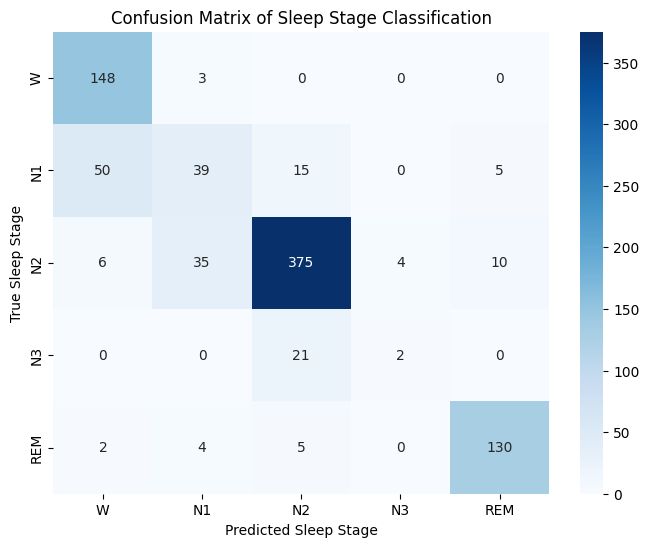

Classification Report:
              precision    recall  f1-score   support

           W       0.72      0.98      0.83       151
          N1       0.48      0.36      0.41       109
          N2       0.90      0.87      0.89       430
          N3       0.33      0.09      0.14        23
         REM       0.90      0.92      0.91       141

    accuracy                           0.81       854
   macro avg       0.67      0.64      0.63       854
weighted avg       0.80      0.81      0.80       854

Cohen's Kappa: 0.721


In [9]:
# Calculate overall accuracy
accuracy = accuracy_score(hypno_ref, hypno_pred_int)
print(f'Overall Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_mat = confusion_matrix(hypno_ref, hypno_pred_int)

# Define labels for sleep stages
labels = ['W', 'N1', 'N2', 'N3', 'REM']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Sleep Stage')
plt.ylabel('True Sleep Stage')
plt.title('Confusion Matrix of Sleep Stage Classification')
plt.show()

# Print the classification report
report = classification_report(hypno_ref, hypno_pred_int, target_names=labels)
print('Classification Report:')
print(report)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(hypno_ref, hypno_pred_int)
print(f"Cohen's Kappa: {kappa:.3f}")


**Evaluation Metrics**: The confusion matrix and classification report provide insights into how well each sleep stage is classified. Cohen's Kappa offers a measure of inter-rater agreement that accounts for chance.

### Additional Statistics and Visualization

#### Plotting Hypnograms for Visual Comparison

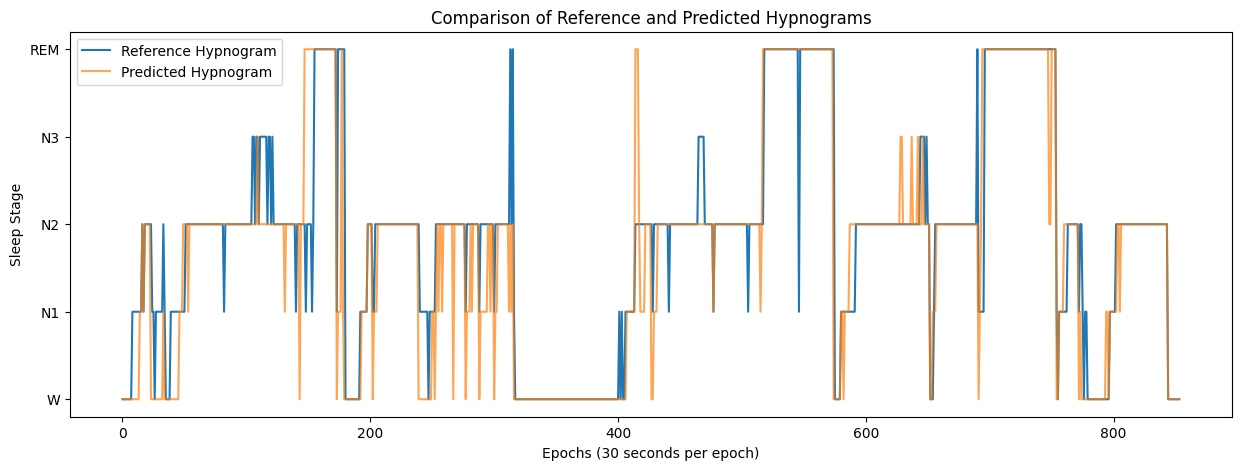

In [10]:
# Plot the reference and predicted hypnograms
plt.figure(figsize=(15, 5))
plt.plot(hypno_ref, label='Reference Hypnogram')
plt.plot(hypno_pred_int, label='Predicted Hypnogram', alpha=0.7)
plt.legend()
plt.xlabel('Epochs (30 seconds per epoch)')
plt.ylabel('Sleep Stage')
plt.title('Comparison of Reference and Predicted Hypnograms')
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=labels)
plt.show()


#### Calculating Per-Class Accuracy


In [11]:
# Calculate accuracy for each sleep stage
per_class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
for i, stage in enumerate(labels):
    print(f'Accuracy for {stage}: {per_class_accuracy[i] * 100:.2f}%')


Accuracy for W: 98.01%
Accuracy for N1: 35.78%
Accuracy for N2: 87.21%
Accuracy for N3: 8.70%
Accuracy for REM: 92.20%
